# MLP autoencoders

An autoencoder is a network which consists of two main parts:
- an *encoder*, which projects the data into a latent space to transform it into a compact representation.
- a *decoder*, which reconstructs the input data from the latent representation.

Autoencoders are very useful in many applications. For instance, in image processing, they are used for image denoising, compression, and generative models (image synthesis and transformation). They can also be used for transfer learning: first an autoencoder is trained to learn a latent representation of the data, and then this representation can be used for other classification/regression tasks.

<center><a href="https://emkademy.medium.com/1-first-step-to-generative-deep-learning-with-autoencoders-22bd41e56d18">
    <img src="https://miro.medium.com/max/772/1*ztZn098tDQsnD5J6v1eNuQ.png" width="600"></a></center>

**Note**: We will study an application of autoencoders to image denoising in lab 6, but here we study a simple autoencoder which compresses and reconstruct an image.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

## Dataset

In [2]:
os.chdir('/mnt/c/Master2/DeepLearning/lab4')

In [3]:
# Define the data repository
data_dir = 'data/'

# Load the MNIST dataset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(400))
test_data = Subset(test_data, torch.arange(50))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [4]:
# Get a batch of images and corresponding labels from the train dataloader
image_batch_example = next(iter(train_dataloader))[0]

## The encoder

First, let us write the encoder. We consider a 3-layer encoder, where each layer consists of a Linear part and a ReLU. The first layer goes from size `input_size` to 128, the second layer from 128 to 64, and the third layer from 64 to 32.

In [5]:
# TO DO: write the encoder class ('__init__' and 'forward' methods)

class MLPencoder(nn.Module):
    def __init__(self, input_size): 
        super(MLPencoder, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, 128), nn.ReLU())
        self.hidden1 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden1(x)
        z = self.hidden2(x)
        return z

In [6]:
# TO DO:
# - instanciate an encoder (get the proper input size)
# - vectorize image_batch_example into image_batch_example_vec
# - apply the encoder to image_batch_example_vec to produce the latent representation z
# - print the size of z
input_size = train_data[0][0][0].shape[0]*train_data[0][0][0].shape[1]
model_example = MLPencoder(input_size)
image_batch_example_vec = image_batch_example.view(-1, 784)
z = model_example(image_batch_example_vec)
print(z.shape)

torch.Size([8, 32])


## The decoder

The decoder as a similar structure than the encoder (3 {Linear + ReLU} layers) but the sizes are flipped: the first layer goes from 32 to 64, then 64 to 128, and then 128 back to the input size.

In [7]:
# TO DO: write the decoder class ('__init__' and 'forward' methods)

class MLPdecoder(nn.Module):
    def __init__(self, input_size): 
        super(MLPdecoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(32, 64), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(64,128), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(128, input_size), nn.ReLU())
    def forward(self, z):
        z = self.layer1(z)
        z = self.layer2(z)
        y = self.layer3(z)
        return y

In [8]:
# TO DO:
# - instanciate a decoder
# - apply it to the latent representation z computed before
# - print the size of the output y (should be the same as the encoder input 'image_batch_example_vec')
decoder_model = MLPdecoder(input_size)
y = decoder_model(z)
print(y.shape)

torch.Size([8, 784])


## The autoencoder main module

Finally we can write the autoencoder module, which consists of the encoder and the decoder.

In [9]:
# TO DO: write the MLP autoencoder class using the previously written encoder and decoder
class MLPAutoencoder(nn.Module):
    def __init__(self, input_size): 
        super(MLPAutoencoder, self).__init__()
        
        self.encoder = MLPencoder(input_size)
        self.decoder = MLPdecoder(input_size)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
# TO DO: Instanciate an MLP autoencoder and print the number of parameters.
ex = MLPAutoencoder(784)(image_batch_example_vec)
ex.shape

torch.Size([8, 784])

In [16]:
model = MLPAutoencoder(input_size=784)

In [17]:
# initialization (ensure reproducibility: everybody should have the same results)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)

torch.manual_seed(0)
model.apply(init_weights)

MLPAutoencoder(
  (encoder): MLPencoder(
    (input_layer): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
    )
    (hidden1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (hidden2): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (decoder): MLPdecoder(
    (layer1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
    )
    (layer2): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
    )
    (layer3): Sequential(
      (0): Linear(in_features=128, out_features=784, bias=True)
      (1): ReLU()
    )
  )
)

In [18]:
print('Total number of parameters:', sum(p.numel() for p in model.parameters()))

Total number of parameters: 222384


<span style="color:red">**Q3**</span> How many parameters are in the autoencoder?

## Training

We can now write the training function. It's very similar to the function for training the MLP classifier (we don't use early stopping here). There are two main differences:
- since we don't try to predict a label, we don't need to load them when iterating over the dataloader.
- the loss function is no longer Cross Entropy (which is for classification), but MSE (*cf.* lab 2).
- as optimizer we no longer use the `SGD`, but `Adam`, which is a better algorithm (but uses the same parameters).

In [26]:
# TO DO: write the training function (you can reuse the code from lab 3 or 4.1)
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
 
   # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    #val_accuracy = []
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, _) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - apply the forward pass (calculate the predicted labels from the vectorized images)
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch
            y_pred = model_tr(images.view(-1, 784))
            l = loss_fn(y_pred, images.view(-1, 784))
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        #accuracy = eval_mlp_classifier(model_tr, eval_dataloader)
        #val_accuracy.append(accuracy)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f},'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model_tr, loss_all_epochs

In [ ]:
# TO DO:
# - Train the autoencoder: 300 epochs, learning rate = 0.001, and MSE loss function
# - After training, save the model parameters and plot the loss over epochs
loss_fn = nn.MSELoss()
num_epochs = 300
lr = 0.001
history = training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, lr, verbose=True)

## Test and visualization

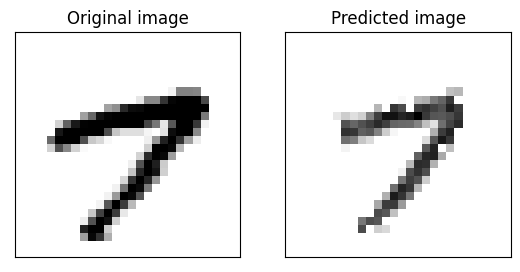

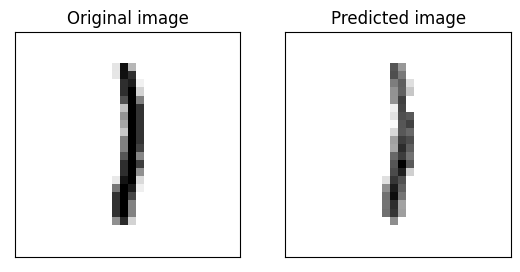

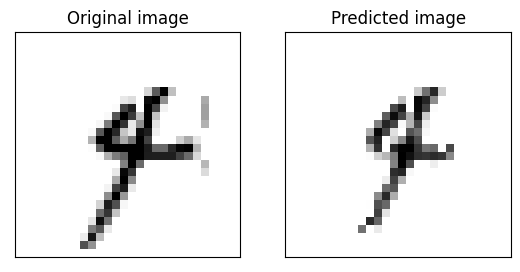

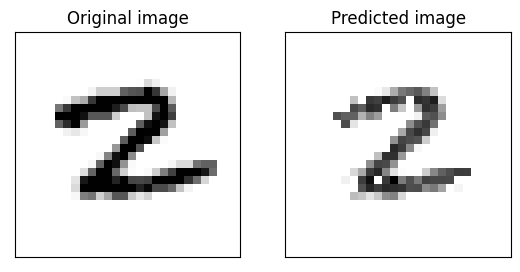

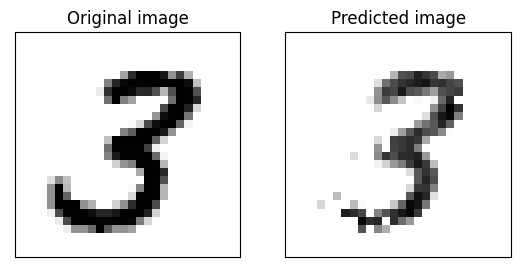

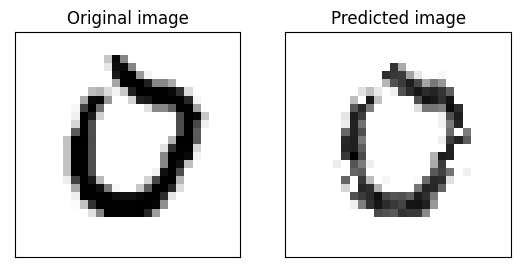

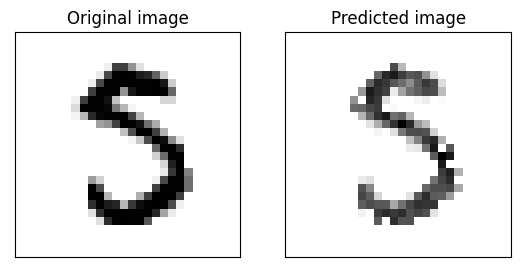

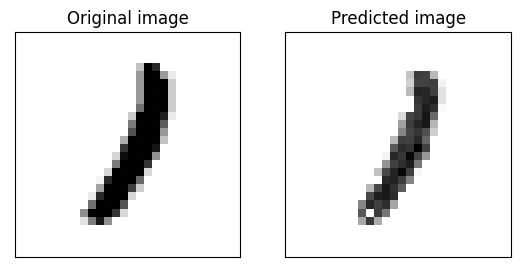

In [29]:
# Apply the autoencoder to the image_batch_example
model = history[0]
predicted_batch_example = model(image_batch_example_vec).detach()

# Reshape it as a black-and-white image (3D tensor)
predicted_batch_example = predicted_batch_example.reshape(batch_size, 1, 28, 28)

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()

<span style="color:red">**Q4**</span> Put one of the plots above in your report (no need to put all of them, we just need one original and the corresponding predicted image).

## Validation loss and early stopping (bonus)



In [36]:
# We define the train and validation sets and dataloaders as in the previous script
n_train_examples = int(len(train_data)*0.9)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(test_data, batch_size=batch_size)

In [54]:
# TO DO: Write the evaluation function.
# It's similar as in the previous script, but we compute the MSE loss, not accuracy (because it's not classification)
def train_val_mlp_autoencoder(model, train_dataloader,eval_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
 
   # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    val_loss = []
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, _) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - apply the forward pass (calculate the predicted labels from the vectorized images)
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch
            images = images.view(-1, 784)
            y_pred = model_tr(images)
            l = loss_fn(y_pred, images)
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        mse_loss = eval_mlp_classifier(model_tr, eval_dataloader)
        val_loss.append(mse_loss)
        if verbose and ((epoch+1)%50 ==0):
            print('Epoch [{}/{}], Loss: {:.4f}, val_loss : {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch, mse_loss))
        
    return model_tr, loss_all_epochs, val_loss

In [51]:
# TO DO: write the training function with validation (you can reuse the code from lab 3 and/or 4.1)
# Be careful: since we compute the validation loss (not accuracy), it should deacrease, not increase
# Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop
def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 
    loss = nn.MSELoss()
    loss_pred = 0
    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        
        # Iterate over the dataset using the dataloader
        for images,_ in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_pred = model(images)
            loss_pred += loss(y_pred, images)
    
    return loss_pred

In [52]:
# Train the model with validation
model = MLPAutoencoder(input_size)
torch.manual_seed(0)
model.apply(init_weights)
model, loss_all_epochs, val_loss_all_epochs = train_val_mlp_autoencoder(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, lr)

Epoch [50/300], Loss: 13.3114, val_loss : 3.2915
Epoch [100/300], Loss: 12.2706, val_loss : 3.3412
Epoch [150/300], Loss: 11.7530, val_loss : 3.3284
Epoch [200/300], Loss: 11.4544, val_loss : 3.3313
Epoch [250/300], Loss: 11.3687, val_loss : 3.3740
Epoch [300/300], Loss: 11.2943, val_loss : 3.3775


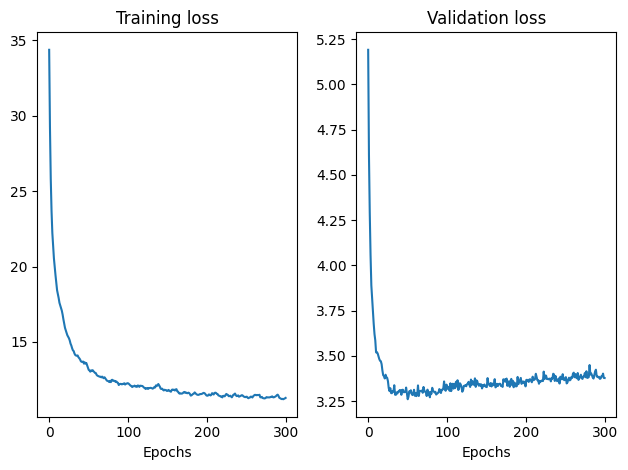

In [53]:
# Plot the training and validation losses over epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(loss_all_epochs)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(val_loss_all_epochs)
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

<span style="color:red">**Q5**</span> Put the plot above in your report (training and validation losses over epochs). What do you observe?